In [1]:
from IPython.display import display

%matplotlib inline
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("jpeg")

import matplotlib
import matplotlib.pyplot as pyplot

import numpy
import polars

from Bio.Seq import Seq

from collections import Counter

polars.enable_string_cache()

In [2]:
"""
Style Matplotlib plots
"""

plot_style = {
    "font.size": 12,
    "font.family": "sans-serif",
    "font.sans-serif": ["Inter"],
    "figure.figsize": [2, 2],
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "figure.facecolor": (1, 1, 1, 0),
    "text.usetex": False,
    "lines.markersize": 3,
    "axes.titleweight": 600,
    "axes.labelweight": 600,
    "axes.labelsize": 9,
    "axes.facecolor": "none",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.5,
    "grid.color": "#303030",
    "grid.alpha": 0.1,
    "xtick.labelsize": 9,
    "xtick.major.width": 1.5,
    "xtick.minor.width": 1,
    "xtick.minor.visible": False,
    "ytick.labelsize": 9,
    "ytick.major.width": 1.5,
    "ytick.minor.width": 1,
    "ytick.minor.visible": False,
    "figure.frameon": False,
    "legend.frameon": False,
    "legend.fancybox": False,
    "legend.fontsize": 9,
    "legend.scatterpoints": 1,
    "legend.markerscale": 1,
    "legend.handlelength": 1.0,
    "legend.handletextpad": 0.2,
    "axes.prop_cycle": matplotlib.cycler(color=["k", "b", "g", "r", "c", "y"]),
}

pyplot.style.use(plot_style)
_ = pyplot.ioff()

cm_white_to_gray = matplotlib.colors.LinearSegmentedColormap.from_list("white_to_gray", ["#ffffff", "#404040"])
cm_light_to_gray = matplotlib.colors.LinearSegmentedColormap.from_list("light_to_gray", ["#e0e0e0", "#404040"])

In [3]:
CRX_WT_DNA = "ATGATGGCGTATATGAACCCGGGGCCCCACTATTCTGTCAACGCCTTGGCCCTAAGTGGCCCCAGTGTGGATCTGATGCACCAGGCTGTGCCCTACCCAAGCGCCCCCAGGAAGCAGCGGCGGGAGCGCACCACCTTCACCCGGAGCCAACTGGAGGAGCTGGAGGCACTGTTTGCCAAGACCCAGTACCCAGACGTCTATGCCCGTGAGGAGGTGGCTCTGAAGATCAATCTGCCTGAGTCCAGGGTTCAGGTTTGGTTCAAGAACCGGAGGGCTAAATGCAGGCAGCAGCGACAGCAGCAGAAACAGCAGCAGCAGCCCCCAGGGGGCCAGGCCAAGGCCCGGCCTGCCAAGAGGAAGGCGGGCACGTCCCCAAGACCCTCCACAGATGTGTGTCCAGACCCTCTGGGCATCTCAGATTCCTACAGTCCCCCTCTGCCCGGCCCCTCAGGCTCCCCAACCACGGCAGTGGCCACTGTGTCCATCTGGAGCCCAGCCTCAGAGTCCCCTTTGCCTGAGGCGCAGCGGGCTGGGCTGGTGGCCTCAGGGCCGTCTCTGACCTCCGCCCCCTATGCCATGACCTACGCCCCGGCCTCCGCTTTCTGCTCTTCCCCCTCCGCCTATGGGTCTCCGAGCTCCTATTTCAGCGGCCTAGACCCCTACCTTTCTCCCATGGTGCCCCAGCTAGGGGGCCCGGCTCTTAGCCCCCTCTCTGGCCCCTCCGTGGGACCTTCCCTGGCCCAGTCCCCCACCTCCCTATCAGGCCAGAGCTATGGCGCCTACAGCCCCGTGGATAGCTTGGAATTCAAGGACCCCACGGGCACCTGGAAATTCACCTACAATCCCATGGACCCTCTGGACTACAAGGATCAGAGTGCCTGGAAGTTTCAGATCTTG"
CRX_WT_AA = Seq(CRX_WT_DNA).translate()
AAs = ["R", "H", "K", "D", "E", "S", "T", "N", "Q", "C", "G", "P", "A", "V", "I", "L", "M", "F", "Y", "W"]

CRX_WT_AA_table = polars.DataFrame(map(lambda t: (t[0]+1, t[1]), enumerate(CRX_WT_AA)), ["position", "residue"])

In [4]:
"""
Common plotting functions
"""

def make_heatmap_figure(heatmap_data, heatmap_value_col, cmap, norm, wt_value):
    heatmap_data_2d = polars.DataFrame(schema=["var_alt"], data=AAs).join(
            polars.DataFrame(schema=["var_pos"], data=list(range(1, 300))).join(
                heatmap_data, how="left", on="var_pos"
            ).pivot(index="var_alt", columns="var_pos", values=heatmap_value_col),
        how="left", on="var_alt"
    ).select(list(map(str, range(1,300)))).to_numpy()
    
    figure, axis = pyplot.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(14, 3))
    
    axis.imshow(heatmap_data_2d, cmap=cmap, norm=norm, aspect="auto", interpolation="none", origin="lower", extent=(0.5, len(CRX_WT_AA)+0.5, -0.5, len(AAs)-0.5))

    wt_heatmap_data = polars.DataFrame(schema=["residue"], data=AAs).join(
        CRX_WT_AA_table.with_columns([
            polars.lit(wt_value).alias("value")
        ]).pivot(values="value", index="residue", columns="position"),
        how="left", on="residue"
    ).select(list(map(str, range(1,300)))).to_numpy()
    axis.imshow(wt_heatmap_data, cmap=cmap, norm=norm, aspect="auto", interpolation="none", origin="lower", extent=(0.5, len(CRX_WT_AA)+0.5, -0.5, len(AAs)-0.5))
    
    wt_positions = CRX_WT_AA_table.with_columns([
        polars.col("residue").replace(dict(zip(AAs, range(len(AAs)))), default=None).alias("ypos")
    ])
    axis.scatter(wt_positions["position"], wt_positions["ypos"], s=3, marker="o", color="#00000080", edgecolors="none")
    
    tick_positions = list(range(len(AAs)))
    tick_labels = AAs.copy()
    
    axis.add_patch(matplotlib.patches.Rectangle((0.5, -4), len(CRX_WT_AA), 2, facecolor="#b3b3b3", edgecolor=None))
    for region in crx_regions.iter_rows(named=True):
        axis.add_patch(matplotlib.patches.Rectangle((region["start"] + 0.5, -4), region["stop"] - region["start"], 2, facecolor=region["color"], edgecolor="#d0d0d0" if region["precedence"] > 0 else "#000000", linewidth=1))
    axis.add_patch(matplotlib.patches.Rectangle((0.5, -4), len(CRX_WT_AA), 2, facecolor="#00000000", edgecolor="#000000", linewidth=1))
    tick_positions.append(-3)
    tick_labels.append("Domains")

    axis.set_xticks([1, 50, 100, 150, 200, 250, 299])
    axis.set_yticks(tick_positions, labels=tick_labels, fontsize=6)
    axis.set(xlim=(-1, len(CRX_WT_AA) + 1), ylim=(-5, len(AAs) + 0.5), xlabel="CRX Position")

    axis.spines["left"].set_visible(False)
    axis.tick_params(axis="y", which="both", length=0)

    colorbar_axis = figure.add_axes([0.905, 0.28, 0.006, 0.5])
    colorbar = figure.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=colorbar_axis, orientation="vertical", drawedges=False)
    colorbar.ax.tick_params(labelsize=8)
    colorbar.outline.set_linewidth(0)
    colorbar.ax.minorticks_off()

    return figure, axis, colorbar

In [5]:
crx_regions = polars.read_csv("external_data_sources/crx_regions.tsv", separator="\t")
display(crx_regions)

region,precedence,start,stop,color
str,i64,i64,i64,str
"""Homeodomain""",0,39,108,"""#ffffff"""
"""Basic""",0,113,120,"""#ffffff"""
"""WSP""",0,161,170,"""#ffffff"""
"""OTX-tail""",0,284,299,"""#ffffff"""
"""α-helix 1""",1,48,60,"""#e0e0e0"""
"""α-helix 2""",1,66,75,"""#e0e0e0"""
"""α-helix 3""",1,80,104,"""#e0e0e0"""


In [6]:
crx_variant_barcodes = []
for residue in CRX_WT_AA:
    crx_variant_barcodes.append({key: Counter() for key in AAs})

In [7]:
barcode_variant_map = polars.read_csv("external_data_sources/barcode_to_variant_map.tsv", separator="\t").filter(polars.col("var_alt") != "X")

display(barcode_variant_map)

BC,var_ref,var_pos,var_alt,read_count
str,str,i64,str,i64
"""ATTGAATTACAGGG…","""V""",242,"""Q""",125
"""GTTGAACCTCAGTA…","""Y""",261,"""A""",137
"""TTATATTAACATAT…","""S""",143,"""Q""",55
"""TGACTTATTCAATT…","""P""",282,"""T""",16
"""TACACTATGCATTG…","""V""",30,"""P""",112
…,…,…,…,…
"""GATAGCCGACAGAA…","""M""",1,"""M""",1
"""ATCCCACAGCAATG…","""F""",296,"""S""",1
"""ATCGAAGTGCATGG…","""Q""",100,"""N""",1


In [8]:
for bc_data in barcode_variant_map.rows(named=True):
    crx_variant_barcodes[bc_data["var_pos"] - 1][bc_data["var_alt"]][bc_data["BC"]] += bc_data["read_count"]

In [9]:
wt_reads = crx_variant_barcodes[0]["M"].total()
wt_barcodes = len(crx_variant_barcodes[0]["M"].keys())

print(f"Wildtype has {wt_reads} reads, {wt_barcodes} barcodes")

Wildtype has 426393 reads, 5514 barcodes


In [10]:
raw_plot_data = []
for i in range(len(CRX_WT_AA)):
    for j in range(len(AAs)):
        counts = crx_variant_barcodes[i][AAs[j]].total()
        num_bcs = len(crx_variant_barcodes[i][AAs[j]].keys())
        if CRX_WT_AA[i] == AAs[j]:
            counts = None
            num_bcs = None
        raw_plot_data.append([i+1, CRX_WT_AA[i], AAs[j], counts, num_bcs])

plot_data = polars.DataFrame(raw_plot_data, schema=["var_pos", "var_ref", "var_alt", "num_reads", "num_bcs"]).filter(polars.col("var_alt") != "X")
display(plot_data)

var_pos,var_ref,var_alt,num_reads,num_bcs
i64,str,str,i64,i64
1,"""M""","""R""",0,0
1,"""M""","""H""",0,0
1,"""M""","""K""",0,0
1,"""M""","""D""",0,0
1,"""M""","""E""",0,0
…,…,…,…,…
299,"""L""","""L""",null,null
299,"""L""","""M""",1247,12
299,"""L""","""F""",982,12


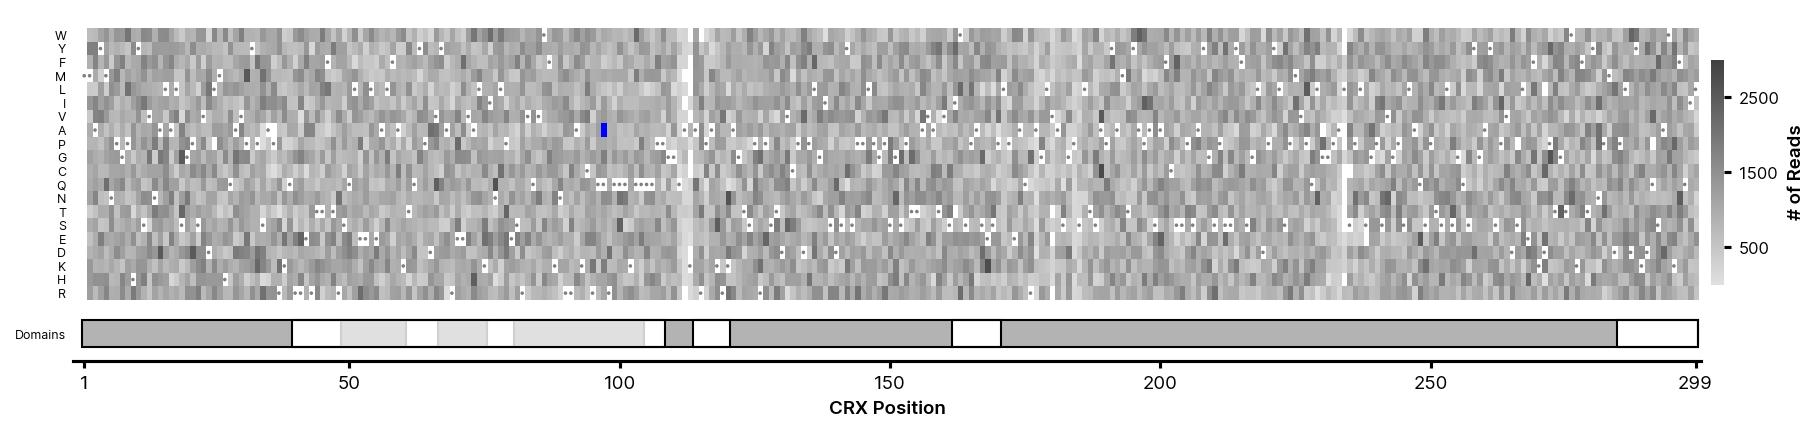

In [11]:
cmap = cm_light_to_gray
cmap.set_bad("#ffffff00")
cmap.set_over("#0000ff")
cmap.set_under("#ffffff00")
norm = matplotlib.colors.Normalize(vmin=1, vmax=3000, clip=False)

figure, axis, colorbar = make_heatmap_figure(plot_data, "num_reads", cmap, norm, 0)

colorbar.set_label("# of Reads")
colorbar.ax.set_yticks([500, 1500, 2500]) 

figure.savefig(f"output/reads_per_variant_heatmap.svg", bbox_inches="tight")
display(figure)
pyplot.close(figure)

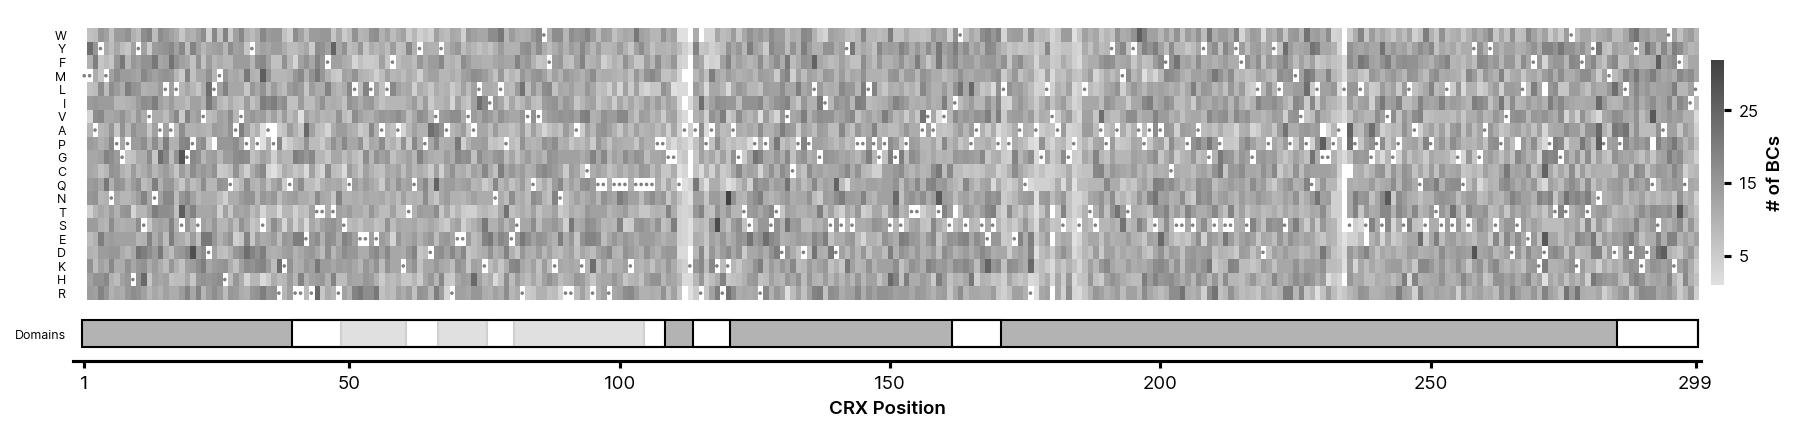

In [12]:
cmap = cm_light_to_gray
cmap.set_bad("#ffffff00")
cmap.set_over("#0000ff")
cmap.set_under("#ffffff00")
norm = matplotlib.colors.Normalize(vmin=1, vmax=32, clip=False)

figure, axis, colorbar = make_heatmap_figure(plot_data, "num_bcs", cmap, norm, 0)

colorbar.set_label("# of BCs")
colorbar.ax.set_yticks([5, 15, 25]) 

figure.savefig(f"output/bc_per_variant_heatmap.svg", bbox_inches="tight")
display(figure)
pyplot.close(figure)

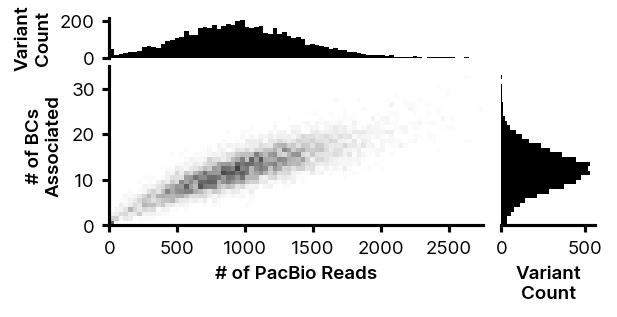

In [13]:
subset = plot_data.filter(
    (polars.col("var_ref") != polars.col("var_alt")) &
    (polars.col("var_alt") != "X") & 
    (polars.col("var_pos") > 1)
)

reads_bounds = (0, 2750)
reads_bins = 80
bc_bounds = (0, 35)
bc_bins = 35

figure = pyplot.figure(layout="constrained", figsize=(4, 2))

axis = figure.add_gridspec(top=0.75, right=0.75).subplots()

reads_hist_axis = axis.inset_axes([0, 1.05, 1, 0.25])
bcs_hist_axis = axis.inset_axes([1.05, 0, 0.25, 1])

reads_hist_axis.spines[["bottom"]].set_visible(False)

bcs_hist_axis.spines[["left"]].set_visible(False)

axis.hist2d(x=subset["num_reads"].to_numpy(), y=subset["num_bcs"].to_numpy(), bins=(reads_bins, bc_bins), cmap=cm_white_to_gray, range=(reads_bounds, bc_bounds), rasterized=True)

reads_hist_axis.hist(x=subset["num_reads"].to_numpy(), bins=reads_bins, range=reads_bounds)
bcs_hist_axis.hist(x=subset["num_bcs"].to_numpy(), orientation="horizontal", bins=bc_bins, range=bc_bounds)

axis.set(xlim=reads_bounds, ylim=bc_bounds, xlabel="# of PacBio Reads", ylabel="# of BCs\nAssociated")
reads_hist_axis.set(xlim=reads_bounds, xticks=[], ylabel="Variant\nCount")
bcs_hist_axis.set(ylim=bc_bounds, yticks=[], xlabel="Variant\nCount")

figure.savefig(f"output/bc+reads_per_variant_distribuation.svg", bbox_inches="tight")
display(figure)
pyplot.close(figure)